<a href="https://colab.research.google.com/github/Justin-Goodrich/Arial-Semantic-Image-Segmentation/blob/main/Arial_Image_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

to do:
- down scale inputs to [0,1] (page 244)
- rewrite process_image into smaller sub functions

# Overview 
This image segmentation project is part of a larger intiaitve that I am taking part in with [NC Space Grant](https://ncspacegrant.ncsu.edu/). The goal of this model is to use binary image segmentation to help a payload, dropped from a weather ballon, avoid undesirable landing locations, such as forests, buildings, roads, and water. 

# Initialization

- basic imports and global variables 

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
# from pathlib import Path
import os
import shutil


In [2]:
DRIVE_DIR = './drive/MyDrive'
DATASET_DIR = 'landcover.ai.v1'

try:
  shutil.copytree(os.path.join(DRIVE_DIR,DATASET_DIR), DATASET_DIR)
except:
  print('datset already exists')

# Data Preperation

for this project, I am using a landcover dataset called [LandCover.ai](https://landcover.ai.linuxpolska.com/).It includes several images taken in Poland and has 4 categories: buildings (1), woodland (2), water(3), and roads(4). For our purposes, the categories dont really matter so I converted the image masks to simple binary masks containing only 1 (all categories) and 0 (unlabeled/empty fields). 

Due to the large number of photos, and their sizes (512 x 512), I experienced frequent kernal crashes both on Google Colab and my own machine. So, I opted to create a data generator using the ``keras.utils.Sequence`` class. This is more memory efficient because it provides traiing data one batch at a time. 

Since the validation set is much smaller than the training set, I decided to simply load those into memory using the `process_images` function. 


In [3]:
def get_image(path, n_channels):
  img = tf.io.read_file(path)
  return tf.io.decode_image(img, channels = n_channels)

In [5]:
def categorical_to_binary(image_tensor, n_categories):
  return tf.math.ceil(image_tensor/n_categories)

In [4]:
def get_image_set(path):
  return (get_image(os.path.join(dir,'{}.jpg'.format(path)),3), categorical_to_binary(get_image(os.path.join(dir,'{}_m.png'.format(path)),1),4))

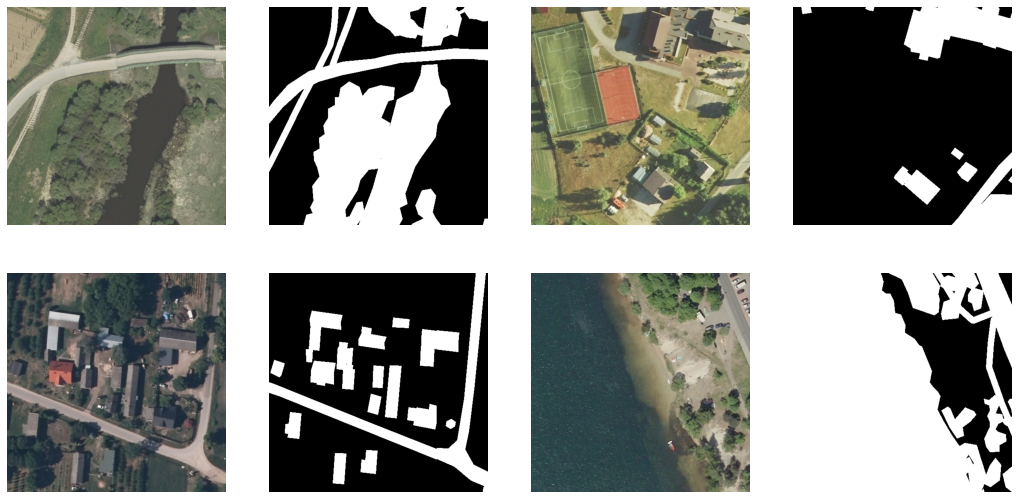

In [15]:
#@title RGB Images and their Corresponding Binary Masks
# reqruite using sample images
dir = os.path.join(DRIVE_DIR, DATASET_DIR,'output')
img_1 = get_image_set('M-34-32-B-b-1-3_311')
img_2 = get_image_set('M-33-20-D-d-3-3_229')
img_3 = get_image_set('M-34-5-D-d-4-2_99')
img_4 = get_image_set('M-34-51-C-d-4-1_283')


fig, ax = plt.subplots(2, 4)
fig.set_size_inches(18,9)
ax[0][0].imshow(img_1[0])
ax[0][0].axis('off')
ax[0][1].imshow(img_1[1][:,:,0], cmap='gray')
ax[0][1].axis('off')
ax[0][2].imshow(img_2[0])
ax[0][2].axis('off')
ax[0][3].imshow(img_2[1][:,:,0], cmap='gray')
ax[0][3].axis('off')

ax[1][0].imshow(img_3[0])
ax[1][0].axis('off')
ax[1][1].imshow(img_3[1][:,:,0], cmap='gray')
ax[1][1].axis('off')
ax[1][2].imshow(img_4[0])
ax[1][2].axis('off')
ax[1][3].imshow(img_4[1][:,:,0], cmap='gray')
ax[1][3].axis('off')

plt.show()


In [6]:
class Image_Generator(tf.keras.utils.Sequence):
  def __init__(self, dir,img_list,l,split,batch_size=1,shuffle=True):
        """
        @param dir: directory containing file lists and output dir
        @param img_list: file containing list of training images provided by dataset
        @param l: length of training/validation set, found on https://landcover.ai.linuxpolska.com/
        """
        self.dir = dir
        self.l = l
        self.img_list = os.path.join(dir,img_list)
        self.batch_size = batch_size
        self.shuffle = shuffle
        self._file = open(self.img_list)
        self.split = split

  def on_epoch_end(self):
        self._file.seek(0, 0)
    
  def __getitem__(self, index):
        batch = []
        features = []
        masks = []
        for i in range(self.batch_size):
          img = self._file.readline()
          jpgtensor = get_image(os.path.join(self.dir,'output','{}.jpg'.format(img.strip())),3)
          pngtensor = get_image(os.path.join(self.dir,'output','{}_m.png'.format(img.strip())),1)
          # pngtensor = tf.cast(pngtensor,tf.dtypes.float32)
          # pngtensor = categorical_to_binary(pngtensor,4)
          pngtensor = keras.utils.to_categorical(pngtensor,5)
          batch.append((jpgtensor,pngtensor))
          features.append(jpgtensor)
          masks.append(pngtensor)
        feature_array = tf.Variable(np.array(features))
        mask_array = tf.Variable(np.array(masks))

        return np.array(features), np.array(masks)
  def __len__(self):
      return int(self.l * self.split)// self.batch_size


In [7]:
def process_images(path):
    # dir = os.path.join(DRIVE_DIR, DATASET_DIR)
    dir = DATASET_DIR
    training = open(os.path.join(dir,path))
    features = []
    masks = []
    for i in training:
        jpgtensor = get_image(os.path.join(dir,'output','{}.jpg'.format(i.strip())),3)
        pngtensor = get_image(os.path.join(dir,'output','{}_m.png'.format(i.strip())),1)
        # pngtensor = tf.cast(pngtensor,tf.dtypes.float32)
        # pngtensor = categorical_to_binary(pngtensor,4)
        pngtensor = keras.utils.to_categorical(pngtensor,5)

        features.append(tf.expand_dims(jpgtensor,axis=0))
        masks.append(tf.expand_dims(pngtensor,axis=0))
    return (np.array(features),np.array(masks))

## Defining Training and validation dataset


In [15]:
# ds_train = Image_Generator(os.path.join(DRIVE_DIR,DATASET_DIR),'train.txt',7470,0.5)
ds_train = Image_Generator(DATASET_DIR,'train.txt',7470,0.9)

ds_validation = tf.data.Dataset.from_tensor_slices(process_images('val.txt'))

In [9]:
def validate_input(input_shape,depth):
    if input_shape % 32 == 0: return (input_shape,input_shape,depth)
    raise Exception("input shape is invalid")

# Building U-Net

In [10]:
def build_UNet(INPUT_SHAPE,NUMBER_OF_CLASSES):

    # checks that input shape is divisible by 32
    inputs = keras.Input(shape=validate_input(INPUT_SHAPE,3))
    input_rescaled = Rescaling(1./255)(inputs)
    l1_c1 = Conv2D(filters=64, kernel_size = 3, padding='same', activation = 'relu')(input_rescaled)
    l1_c2= Conv2D(filters=64, kernel_size = 3, padding='same', activation = 'relu')(l1_c1)

    max_1 = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(l1_c2)

    l2_c1 = Conv2D(filters=128, kernel_size = 3, padding='same', activation = 'relu')(max_1)
    l2_c2 = Conv2D( filters=128, kernel_size = 3, padding='same', activation = 'relu')(l2_c1)

    max_2 = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(l2_c2) 


    l3_c1 = Conv2D(filters=256, kernel_size = 3, padding='same', activation = 'relu')(max_2)
    l3_c2 = Conv2D(filters=256, kernel_size = 3, padding='same', activation = 'relu')(l3_c1)

    max_3 = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(l3_c2) 

    l4_c1 = Conv2D(filters=512, kernel_size = 3, padding='same', activation = 'relu')(max_3)
    l4_c2 = Conv2D(filters=512, kernel_size = 3, padding='same', activation = 'relu')(l4_c1)

    max_4 = MaxPool2D(pool_size=(2,2), strides=2, padding='same')(l4_c2) 

    l5_c1 = Conv2D(filters=1024, kernel_size = 3, padding='same', activation = 'relu')(max_4)
    l5_c2 = Conv2D(filters=1024, kernel_size = 3, padding='same', activation = 'relu')(l5_c1)


    # upconvolution 

    up1 = Conv2DTranspose(filters=512, kernel_size = 2, strides=(2, 2), padding='same')(l5_c2)
    up1_l1 = concatenate(inputs=[up1,l4_c2], axis=3)
    up1_l2 = Conv2D(filters=512, kernel_size = 3, padding='same', activation = 'relu')(up1_l1)
    up1_l3 = Conv2D(filters=512, kernel_size = 3, padding='same', activation = 'relu')(up1_l2)

    up2 = Conv2DTranspose(filters=256, kernel_size = 2, strides=(2, 2), padding='same')(up1_l3)
    up2_l1 = concatenate(inputs=[up2,l3_c2], axis=3)
    up2_l2 = Conv2D(filters=256, kernel_size = 3, padding='same', activation = 'relu')(up2_l1)
    up2_l3 = Conv2D(filters=256, kernel_size = 3, padding='same', activation = 'relu')(up2_l2)

    up3 = Conv2DTranspose(filters=128, kernel_size = 2, strides=(2, 2), padding='same')(up2_l3)
    up3_l1 = concatenate(inputs=[up3,l2_c2], axis=3)
    up3_l2 = Conv2D(filters=128, kernel_size = 3, padding='same', activation = 'relu')(up3_l1)
    up3_l3 = Conv2D(filters=128, kernel_size = 3, padding='same', activation = 'relu')(up3_l2)

    up4 = Conv2DTranspose(filters=64, kernel_size = 2, strides=(2, 2), padding='same')(up3_l3)
    up4_l1 = concatenate(inputs=[up4,l1_c2], axis=3)
    up4_l2 = Conv2D(filters=64, kernel_size = 3, padding='same', activation = 'relu')(up4_l1)
    up4_l3 = Conv2D(filters=64, kernel_size = 3, padding='same', activation = 'relu')(up4_l2)

    outputs = Conv2D(filters=NUMBER_OF_CLASSES, kernel_size = 1, padding='same', activation = 'softmax')(up4_l3)

    return keras.Model(inputs=inputs, outputs=outputs, name="UNET")



In [13]:
UNet = build_UNet(512,5)

UNet.compile(
    loss=tf.keras.losses.CategoricalCrossentropy(),
    optimizer = keras.optimizers.SGD(learning_rate=0.01),
    metrics=['accuracy', tf.keras.metrics.CategoricalAccuracy()]
)

UNet.summary()

Model: "UNET"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 rescaling_1 (Rescaling)        (None, 512, 512, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv2d_19 (Conv2D)             (None, 512, 512, 64  1792        ['rescaling_1[0][0]']            
                                )                                                                 
                                                                                               

In [ ]:
# history = UNet.fit(ds_train, batch_size=1,epochs=1000, validation_data=ds_validation)
# UNet.save(os.path.join(DRIVE_DIR, 'weights','prototype_3'))
history = UNet.fit(ds_train, batch_size=1,epochs=100, validation_data=ds_validation)
UNet.save_weights(os.path.join(DRIVE_DIR,'weights/prototype_3'))
# this works, just add validation by refactoring its dataset


Epoch 1/100
6723/6723 [==============================] - 313s 47ms/step - loss: 0.5626 - accuracy: 0.7856 - categorical_accuracy: 0.7856 - val_loss: 0.9871 - val_accuracy: 0.6713 - val_categorical_accuracy: 0.6713
Epoch 2/100
6723/6723 [==============================] - 312s 46ms/step - loss: 0.4587 - accuracy: 0.8313 - categorical_accuracy: 0.8313 - val_loss: 0.8386 - val_accuracy: 0.6968 - val_categorical_accuracy: 0.6968
Epoch 3/100
6723/6723 [==============================] - 318s 47ms/step - loss: 0.3649 - accuracy: 0.8692 - categorical_accuracy: 0.8692 - val_loss: 0.8124 - val_accuracy: 0.7055 - val_categorical_accuracy: 0.7055
Epoch 4/100
6723/6723 [==============================] - 314s 47ms/step - loss: 0.3353 - accuracy: 0.8784 - categorical_accuracy: 0.8784 - val_loss: 0.8580 - val_accuracy: 0.6869 - val_categorical_accuracy: 0.6869
Epoch 5/100
6723/6723 [==============================] - 307s 46ms/step - loss: 0.3146 - accuracy: 0.8859 - categorical_accuracy: 0.8859 - val_l

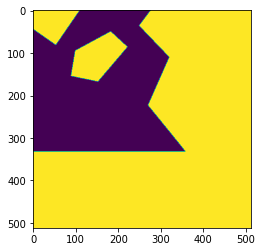

In [ ]:
x,m = ds_train.__getitem__(1)
plt.imshow(m[0][:,:,0])

In [ ]:


history.history.keys()
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(loss, label='training loss')
plt.plot(val_loss, label='validation loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()


plt.show()

In [ ]:
plt.plot(acc, label='training accuracy')
plt.plot(val_acc, label='validation accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()


plt.show()